## Prevendo a Intencão de Compras de Usuário usando SVM

## Importando os Pacotes

In [4]:
# Importando os pacotes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Carga dos Dados

In [5]:
# Carregando os dados
df_original = pd.read_csv("online_shoppers_intention.csv")
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise Exploratória

In [6]:
# Shape dos dados
df_original.shape

(12330, 18)

In [7]:
# Os tipos de dados
df_original.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [8]:
# Verificando se existe valores NaN
df_original.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [9]:
# Removendo as linhas com valores ausentes
df_original.dropna(inplace=True)

In [10]:
# Aqui removemos todos os NaN
df_original.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [11]:
# Shape dos dados
df_original.shape

(12316, 18)

In [12]:
# Verificando valores unicos
df_original.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

Dividirei os dados em variáveis contínuas e categóricas, Trataremos todas as variáveis com menos de 30 entradas únicas como categóricas.

In [13]:
# Criar uma cópia do dataset original
df = df_original.copy()

# Lista de vazias para o resultado
continuous = []
categorical = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)

In [14]:
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [15]:
# Variáveis contínuas
df[continuous].head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


In [16]:
# Variáveis contínuas
df[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


## Gráficos para as variáveis numéricas.

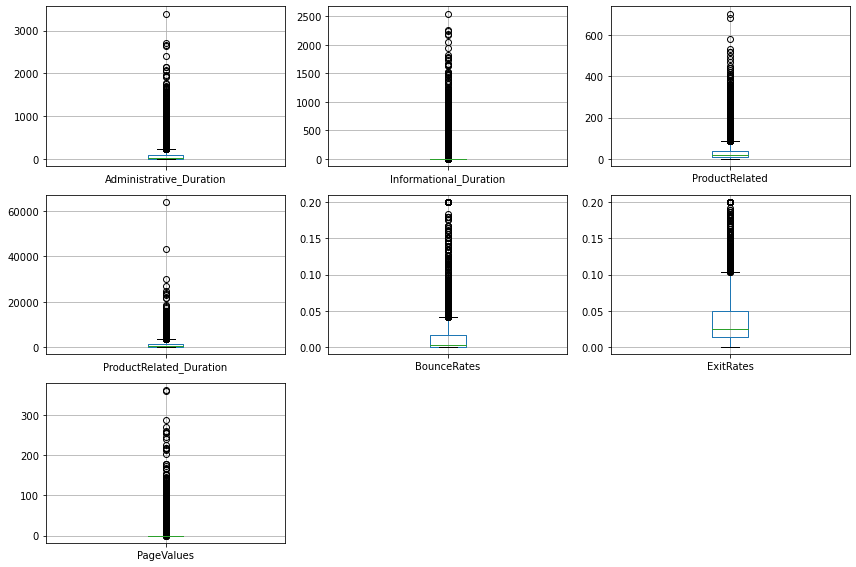

In [17]:
# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(3,3, i + 1);
    df.boxplot(col)
    plt.tight_layout()

Variáveis contínuas parecem extremamente distorcidas. Vamos aplicar transformação de log para melhor visualização.

In [18]:
# Transformação de log nas variáveis contínuas
df[continuous] = np.log1p(1 + df[continuous])

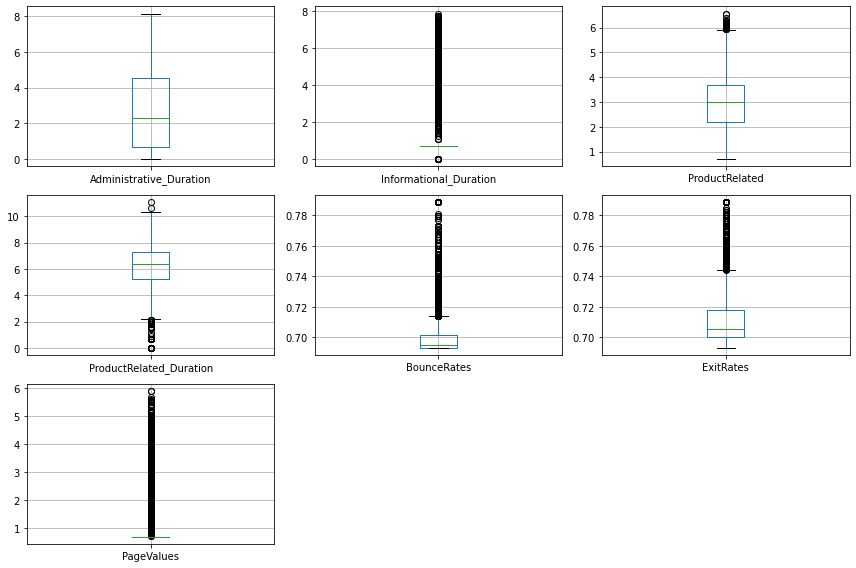

In [19]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variaveis continuas
for i, col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()

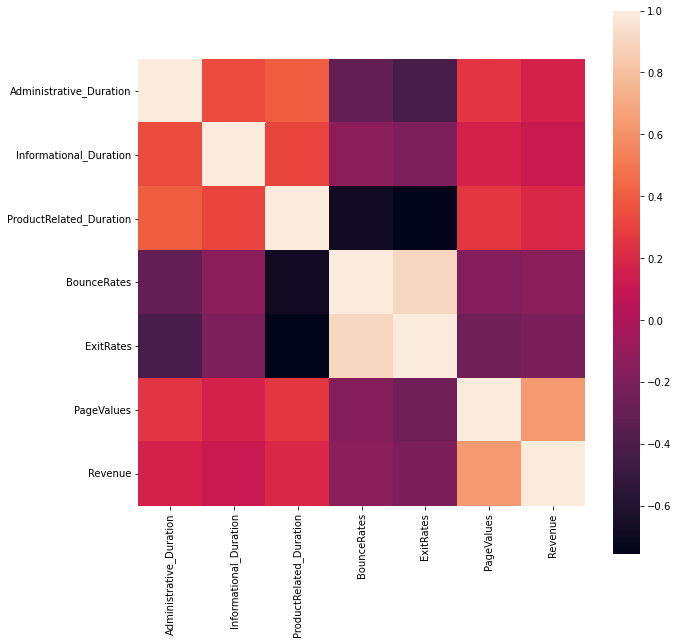

In [20]:
# Matriz de Correlação Entre Variáveis Contínuas.
# Área de plotagem
plt.figure(figsize = (10,10))

# Matriz de Correlação 
sns.heatmap(df[['Administrative_Duration',
                'Informational_Duration',  
                'ProductRelated_Duration',
                'BounceRates', 
                'ExitRates', 
                'PageValues',
                'Revenue']].corr(), vmax = 1., square = True)

### Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

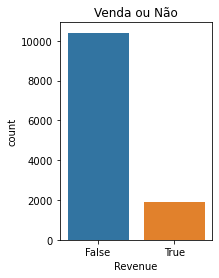

In [21]:
# Countplot Venda ou não
plt.subplot(1,2,2)
plt.title("Venda ou Não")
sns.countplot(df['Revenue'])

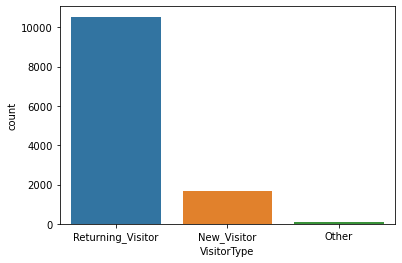

In [22]:
# Countplot tipo de Visitante
plt.xlabel("Tipo de Visitante")
sns.countplot(df['VisitorType'])

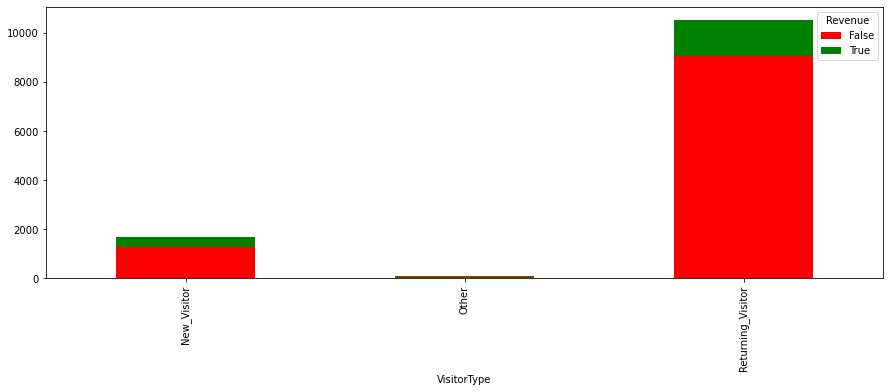

In [23]:
# Gráfico de bar Tipo de Visitante x Revenue
pd.crosstab(df["VisitorType"], df["Revenue"]).plot(kind = 'bar',
                                                  stacked = True,
                                                  figsize = (15,5),
                                                  color = ['red', 'green'])

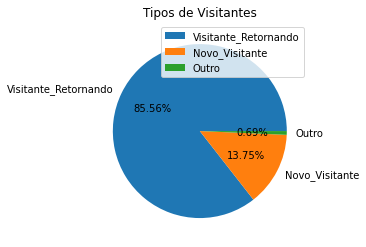

In [24]:
# Gráfico de pizza Tipos de Visitantes
labels = ['Visitante_Retornando', 'Novo_Visitante', 'Outro']
plt.title("Tipos de Visitantes")
plt.pie(df['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()

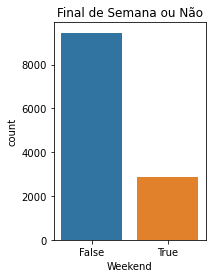

In [25]:
# Countplot Final de Semana ou Não
plt.subplot(1,2,1)
plt.title("Final de Semana ou Não")
sns.countplot(df['Weekend'])

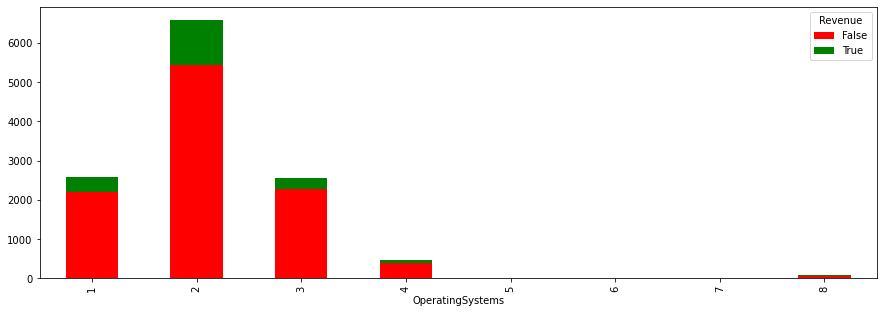

In [26]:
# Gráfico de Barra Tipo de SO x Revenue
pd.crosstab(df['OperatingSystems'], df['Revenue']).plot(kind = 'bar',
                                                       stacked = True,
                                                       figsize = (15,5),
                                                       color = ("red", "green"))

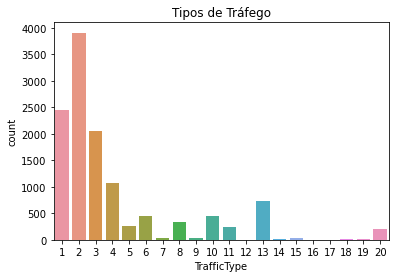

In [27]:
# Countplot Tipo de Tráfego
plt.title('Tipos de Tráfego')
plt.xlabel("Tipos de Tráfego")
sns.countplot(df['TrafficType'])

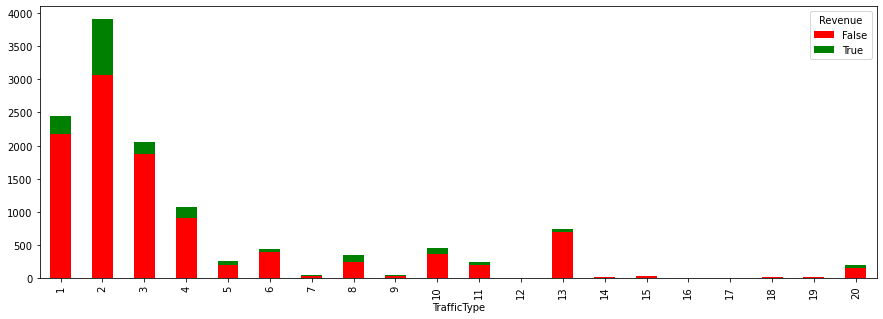

In [28]:
# Gráfico de barras Tipo de Tráfego x Revenue
pd.crosstab(df['TrafficType'], df['Revenue']).plot(kind = 'bar',
                                                  stacked = True,
                                                  figsize = (15, 5),
                                                  color = ('red', 'green'))

## Pré-Processamento dos Dados

In [29]:
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [30]:
# Cria o encoder
lb = LabelEncoder()

# Aplica o encoder nas variáveis que estão com string
df_original['Month'] = lb.fit_transform(df_original['Month'])
df_original['VisitorType'] = lb.fit_transform(df_original['VisitorType'])

# Remove valores missing eventualmente gerados
df_original.dropna(inplace=True)

In [31]:
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True,False


In [32]:
# Shape
df_original.shape

(12316, 18)

In [33]:
# Verificando se a variável resposta está baleanceada
target_count = df_original['Revenue'].value_counts()
target_count

False    10408
True      1908
Name: Revenue, dtype: int64

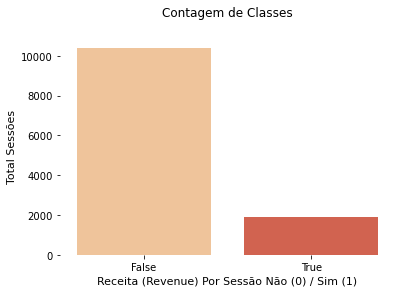

In [34]:
# Plot
sns.countplot(df_original['Revenue'], palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [35]:
# Variáveis explicativas
df_original.iloc[:, 0:17].head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True


In [36]:
# Variável Target
df_original.iloc[:, 17].head()

0    False
1    False
2    False
3    False
4    False
Name: Revenue, dtype: bool

### Balanceamento de Classe - Oversampling

In [37]:
# Importa a função
from imblearn.over_sampling import SMOTE

# Seed
seed = 1000

# Separa X e y
X = df_original.iloc[:, 0:17]
y = df_original.iloc[:, 17]

# Cria o balanceador Smote
smote_bal = SMOTE(random_state=seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X,y)

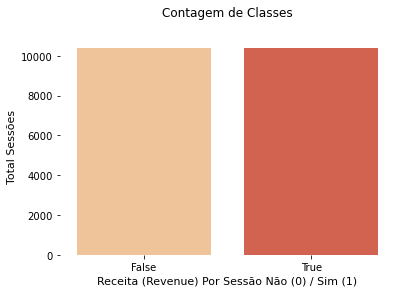

In [44]:
# Plot
sns.countplot(y_res, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [46]:
# Shape dos dados originais
df_original.shape

(12316, 18)